In [120]:
import matplotlib.pyplot as plt
import torch

This tutorial will demonstrate how to use DFlat for field propagation and how to compute gradiets through this operation.

First we start by initializing a lens. We typically begin optimization with a focusing profile on our optic since it helps with convergence.

(2, 513, 513) (2, 513, 513) (1, 513, 513)


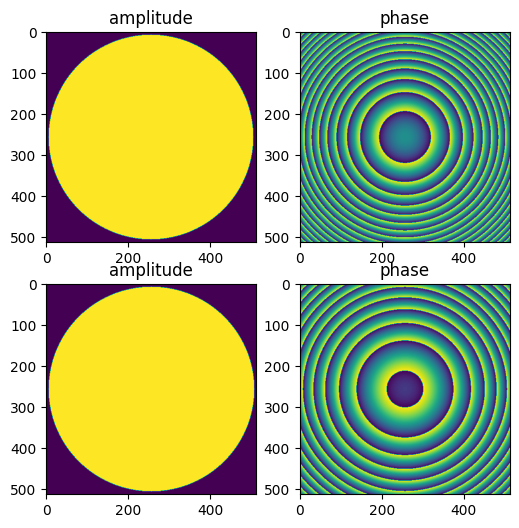

In [128]:
from dflat.initialize import focusing_lens

amp, phase, aperture = focusing_lens(
    in_size=[513,513],                             # Size of the input grid along x and y
    in_dx_m=[1e-6, 1e-6],                      # Discretization of input field grid along x and y
    wavelength_set_m=[400e-9, 600e-9],             # We can generate focusing profiles for multiple wavelengths as a stack of output profiles
    depth_set_m=[1e3, 1e3],                        # focused to far distances (approx infinity focused)
    fshift_set_m=[[0.0, 0.0], [0.0, 0.0]],         # Shifts the PSF translationally on the photosensor
    out_distance_m=1e-2,                                             
    aperture_radius_m=250e-6,
    radial_symmetry=False
)
print(amp.shape, phase.shape, aperture.shape)

n = amp.shape[0]
fig, ax = plt.subplots(n,2,figsize=(6,3*n))
for i in range(n):
    ax[i,0].imshow(amp[i]*aperture[0], vmin=0, vmax=1)
    ax[i,0].set_title("amplitude")
    ax[i,1].imshow(phase[i])
    ax[i,1].set_title("phase");

Let's propagate the fields. To propagate a complex field from one plane to another in space, we can use the Fresnel or Angular Spectrum Algorithm. These are written in pytorch via the two following classes:
- FresnelPropagation
- ASMPropagation
  
Our propagation code enables you to compute the field on a uniform output grid that is different than the initial grid. Keep in mind that this calculation is done behind the scenes in frequency space and that is a non-intuitive memory/compute scaling relationship when you tune the output grid size and pixel pitch. Doubling the output grid does not simply double the compute or memory. 

Also you should know that both methods have completely different compute costs for the same problem! In general, I default to the angular spectrum method because it handles broadband efficiently with batches but Fresnel can sometimes be more efficient if you need a very fine output grid. 

To further probe this, you can set verbose=True during class initialization.

The input to the forward function of these classes expect tensors of the shape [Batch, Wavelength, H, W]. If radial symetry acceleration is used, it would be [Batch, Wavelength, 1, Radial_length]

In [122]:
from dflat.propagation import FresnelPropagation, ASMPropagation

Fresnel = FresnelPropagation(
    in_size=[513,513],                 # corresponds to the profiles above 
    in_dx_m=[1e-6, 1e-6],          # that we aready initialized
    out_distance_m=1e-2,
    out_size=[128, 128],
    out_dx_m=[5e-6, 5e-6],
    wavelength_set_m=[400e-9],
    verbose=True
).to('cuda')

ASM = ASMPropagation(
    in_size=[513,513],                 # corresponds to the profiles above 
    in_dx_m=[1e-6, 1e-6],          # that we aready initialized
    out_distance_m=1e-2,
    out_size=[128, 128],
    out_dx_m=[5e-6, 5e-6],
    wavelength_set_m=[400e-9],
    verbose=True
).to('cuda')

Initializing the Fresnel Method: 
   - in_size: [513 513], calc_in_size:
      [513. 513.],
   - padded_calc_in_size: 
      [801. 801.],
   - in_dx: [1. 1.], calc_in_dx: 
      [1. 1.],
   - out_dx: [5. 5.], calc_out_dx: 
      [4.9937578 4.9937578],
Initializing the Angular Spectrum Method
   - in_size: [513 513], calc_in_size: [513. 513.], padded_calc_in_size: [641. 641.]
   - in_dx: [1. 1.], calc_in_dx: [1. 1.]
   - out_dx: [5. 5.], calc_out_dx: [1. 1.]
   - Resampling to grid size: [5. 5.]


We run this calculation now and plot the output field for the corresponding input profile made previously.
Note that we generated a stack of two different phase profiles from before. Below, we are going to treat the two as a batch dimension and propagate the complex field assuming an incindent wavelength of 400 nm. 

Notice that you could have defined the input fields to have a batch dimension of 1 and set wavelength_set_m to be two values like [400e-9, 600e-9]. These both will work but they correspond to two different operations! You use both of them for different tasks. Try to think of them. 

/home/deanhazineh/anaconda3/envs/dflat/lib/python3.11/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


torch.Size([2, 1, 128, 128])


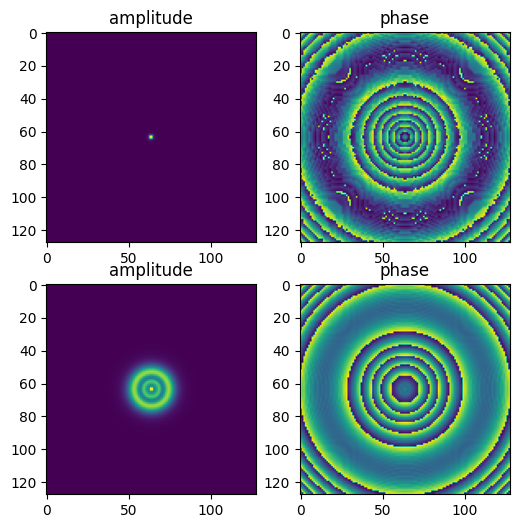

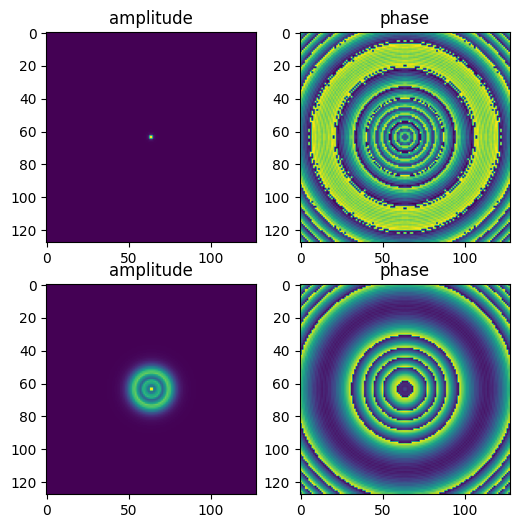

In [123]:
# The two profiles are treated here as a batch of lenses to propagate the fields for at one wavelength (specified in the init argument)
amp1, phase1 = Fresnel(amp[:, None]*aperture[None], phase[:, None])
amp2, phase2 = ASM(amp[:, None]*aperture[None], phase[:,None])

print(amp1.shape)

n = amp.shape[0]
fig, ax = plt.subplots(n,2,figsize=(6,3*n))
for i in range(n):
    ax[i,0].imshow(amp1[i,0].cpu().numpy()**2)
    ax[i,0].set_title("amplitude")
    ax[i,1].imshow(phase1[i,0].cpu().numpy())
    ax[i,1].set_title("phase")


n = amp.shape[0]
fig, ax = plt.subplots(n,2,figsize=(6,3*n))
for i in range(n):
    ax[i,0].imshow(amp2[i,0].cpu().numpy()**2)
    ax[i,0].set_title("amplitude")
    ax[i,1].imshow(phase2[i,0].cpu().numpy())
    ax[i,1].set_title("phase")

If you are doing imageing, you want to compute the point-spread function instead of just propagating fields. You can do this with the PSF class. 
- PointSpreadFunction
- 
Use the diffraction_engine setting to initialize to the ASM or Fresnel backend which is the same as that called above. THe convenient part of this function is that it handles generating the curved/spherical wavefront that hits the lens from a point-source at a distance away.
 It also handles normalization so the intensity at the output is already normalized relative to the total amout of light that hit the aperture! These are fully functional PSFs for rendering

In [124]:
from dflat.propagation import PointSpreadFunction

PSF = PointSpreadFunction(
    in_size=[513,513],                 
    in_dx_m=[1e-6, 1e-6],         
    out_distance_m=1e-2,
    out_size=[200, 200],
    out_dx_m=[1e-6, 1e-6],
    wavelength_set_m=[400e-9],
    diffraction_engine="ASM",
    verbose=True
)

Initializing the Angular Spectrum Method
   - in_size: [513 513], calc_in_size: [513. 513.], padded_calc_in_size: [513. 513.]
   - in_dx: [1. 1.], calc_in_dx: [1. 1.]
   - out_dx: [1. 1.], calc_out_dx: [1. 1.]
   - Resampling to grid size: [1. 1.]


You should read the docstrings for the functions but we expect a shape of [Batch, Wavelength, H, W] for our input tensors. 
The output has shape [Batch, Num_Point_Sources, Wavelength, H, W]

torch.Size([2, 3, 1, 200, 200])
tensor([[0.9836, 0.9836, 0.9835],
        [0.9511, 0.9461, 0.9401]])


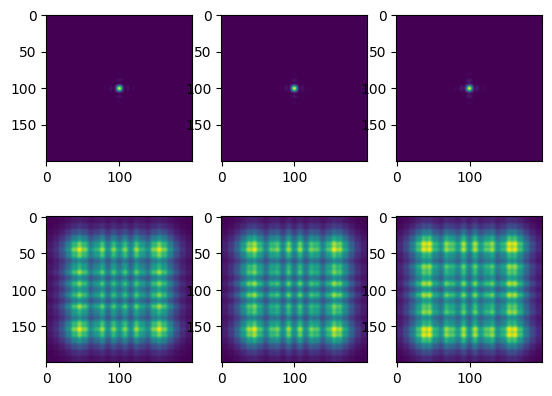

In [125]:
point_source_locs = [[0.0, 0.0, 1e3], [0.0, 0.0, 1.0], [0.0, 0.0, 0.5]] # Define point source locations

psf_intensity, psf_phase = PSF(amp[:, None], phase[:,None], point_source_locs)
print(psf_intensity.shape)

fig, ax = plt.subplots(2,len(point_source_locs))
for i in range(2):
    for j in range(len(point_source_locs)):
        ax[i,j].imshow(psf_intensity[i,j,0])

print(torch.sum(psf_intensity, axis=(-1,-2,-3)))


Given an autodifferentiable field propagation, we can now make holograms via optimization. DFlat enables more complex types of hologram optimization but this is the simplest task to give you an idea so you can get started on other cool stuff

Initializing the Angular Spectrum Method
   - in_size: [513 513], calc_in_size: [513. 513.], padded_calc_in_size: [513. 513.]
   - in_dx: [1. 1.], calc_in_dx: [1. 1.]
   - out_dx: [1. 1.], calc_out_dx: [1. 1.]
   - Resampling to grid size: [1. 1.]
torch.Size([128, 128])


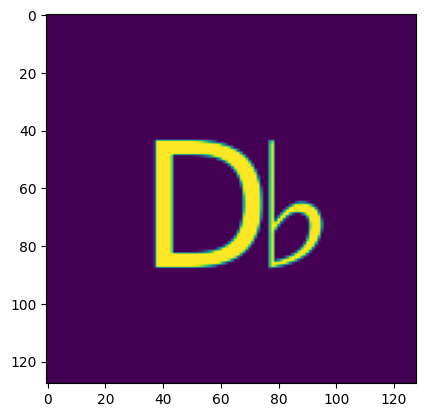

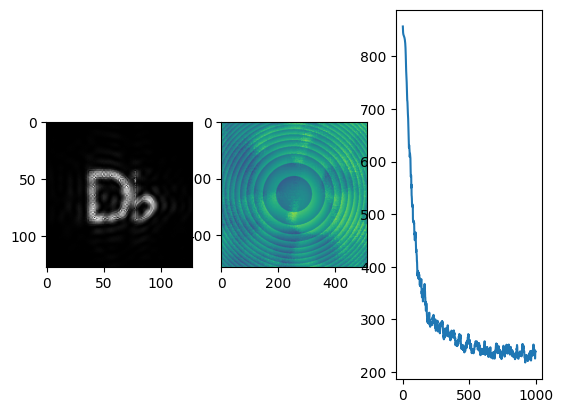

In [168]:
# all we are going to do here is optimize a phase profile to produce a target intensity pattern
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import requests
from io import BytesIO

def generate_d_flat_image(size, font_size):
    img = Image.new('L', size, color=0)  # 'L' mode for grayscale, black background
    draw = ImageDraw.Draw(img)
    
    font = ImageFont.truetype("DejaVuSans.ttf", font_size)
    
    d_position = (size[0] // 4, size[1] // 4)
    draw.text(d_position, "D", font=font, fill=255)
    flat_position = (d_position[0] + font_size // 2+10, d_position[1])
    draw.text(flat_position, "♭", font=font, fill=255)
    
    img_tensor = torch.tensor(np.array(img), device='cuda', dtype=torch.float32) / 255.0
    return img_tensor

target_pattern = generate_d_flat_image((128, 128), font_size=60)
target_pattern = target_pattern / target_pattern.sum()
fig, ax = plt.subplots(1,1)
ax.imshow(target_pattern.cpu().numpy())

##
target_pattern = target_pattern.to(dtype=torch.float32, device='cuda')
in_size = [513, 513]
init_amp = torch.tensor(amp, dtype=torch.float32, device='cuda', requires_grad=False)
init_phase = torch.tensor(phase, dtype=torch.float32, device='cuda', requires_grad=True)
PSF = PointSpreadFunction(
    in_size=in_size,                 
    in_dx_m=[1e-6, 1e-6],         
    out_distance_m=1e-2,
    out_size=[128, 128],
    out_dx_m=[1e-6, 1e-6],
    wavelength_set_m=[400e-9],
    diffraction_engine="ASM",
    verbose=True
).to('cuda')
optimizer = optim.Adam([init_phase], lr=1e-1)
num_iterations = 1000
losses = []

for i in range(num_iterations):
    optimizer.zero_grad()
    intensity, _ = PSF(init_amp[None], init_phase[None], [[0.0, 0.0, 1e3]])
    intensity = intensity.squeeze()

    #loss = torch.sum(torch.abs(intensity / intensity.max() - target_pattern / target_pattern.max()))
    loss = torch.sum((intensity / intensity.max() - target_pattern / target_pattern.max())**2)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # if i % 1 == 0:
    #     print(f'Iteration {i}/{num_iterations}, Loss: {loss.item()}')

# Visualize the final hologram pattern
print(intensity.shape)
fig, ax = plt.subplots(1,3)
ax[0].imshow(intensity.detach().cpu().numpy(), cmap='gray')
ax[1].imshow(init_phase.squeeze().detach().cpu().numpy())
ax[2].plot(losses)